In [5]:
%pip install --quiet qutip qutip-qip qiskit qiskit-aer pylatexenc pandas &> /dev/null

Note: you may need to restart the kernel to use updated packages.


In [1]:
import qutip as qt
from qutip import Qobj
from qiskit import QuantumCircuit, QuantumRegister
from qutip_qip.circuit import QubitCircuit
from qutip_qip.operations import *
from qiskit.quantum_info import Operator, process_fidelity, Choi, Operator, DensityMatrix, Kraus, SuperOp, Pauli

import pandas as pd
import numpy as np
from scipy.linalg import polar, logm
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product

In [2]:
sx, sy, sz = qt.sigmax(), qt.sigmay(), qt.sigmaz()
I = qt.qeye(2)

paulis = [I, sx, sy, sz]
pauli_labels = ['I', 'X', 'Y', 'Z']

In [3]:
def pulse_shape(shape="cos", A=1.0, delta=0.0, sigma=0.1, alpha=0.5, chirp_rate=0.0):

    if shape == "cos":
        return lambda t, args: A * np.cos(delta * t)

    elif shape == "gaussian":
        return lambda t, args: A * np.exp(-((t - 0.5)**2) / (2 * sigma**2))

    elif shape == "square":
        return lambda t, args: A if 0.3 <= t <= 0.7 else 0.0

    elif shape == "chirp":
        return lambda t, args: A * np.cos((delta + chirp_rate * t) * t)

    elif shape == "drag":
        return lambda t, args: A * (np.exp(-((t - 0.5)**2)/(2 * sigma**2))
                                   - alpha * (t - 0.5) / sigma**2 * np.exp(-((t - 0.5)**2)/(2 * sigma**2)))

    else:
        raise ValueError(f"Unknown pulse shape: {shape}")


In [5]:
def apply_eve_multi_attack(state_pre, J12=0.1, J01=0.1, A=(1.0, 1.0),
                            delta=(0.0, 0.0), coup_12=(qt.sigmaz(), qt.sigmax()),
                            coup_01=(qt.sigmax(), qt.sigmax()),
                            shape=("cos", "cos"),
                            extra_params=({}, {})):
    A0, A1 = A
    delta0, delta1 = delta
    s1_12, s2_12 = coup_12
    s0_01, s1_01 = coup_01
    shape0, shape1 = shape
    kwargs0, kwargs1 = extra_params

    I = qt.qeye(2)

    # Coupling terms
    H_couple_12 = J12 * qt.tensor(I, s1_12, s2_12)
    H_couple_01 = J01 * qt.tensor(s0_01, s1_01, I)

    # Time-dependent drive terms
    coeff0 = pulse_shape(shape=shape0, A=A0, delta=delta0, **kwargs0)
    coeff1 = pulse_shape(shape=shape1, A=A1, delta=delta1, **kwargs1)

    H_p0 = [qt.tensor(qt.sigmax(), I, I), coeff0]
    H_p1 = [qt.tensor(I, qt.sigmax(), I), coeff1]

    H = [H_couple_12, H_couple_01, H_p0, H_p1]

    t_attack = np.linspace(0, 1.0, 50)
    sol = qt.mesolve(H, state_pre, t_attack, [], [])
    return sol.states[-1]


Process Tomography

In [6]:
def prepare_input_states():
    return [
        qt.basis(2, 0),  # |0⟩
        qt.basis(2, 1),  # |1⟩
        (qt.basis(2, 0) + qt.basis(2, 1)).unit(),  # |+⟩
        (qt.basis(2, 0) + 1j * qt.basis(2, 1)).unit()  # |+i⟩
    ]

In [7]:
def apply_eve_process_on_q2(input_state,
                            J12=0.1, J01=0.1,
                            A=(1.0, 1.0),
                            delta=(0.0, 0.0),
                            coup_12=(qt.sigmaz(), qt.sigmax()),
                            coup_01=(qt.sigmax(), qt.sigmax()),
                            shape=("cos", "cos"),
                            extra_params=({}, {})):
    full_state = qt.tensor(qt.basis(2, 0), qt.basis(2, 0), input_state)
    final_state = apply_eve_multi_attack(
        state_pre=full_state,
        J12=J12,
        J01=J01,
        A=A,
        delta=delta,
        coup_12=coup_12,
        coup_01=coup_01,
        shape=shape,
        extra_params=extra_params
    )
    return final_state.ptrace(2)

In [10]:
def perform_qpt(J12=0.2, J01=0.1, A=(1.0, 1.0), delta=(0.0, 0.0),
                coup_12=(qt.sigmaz(), qt.sigmax()), coup_01=(qt.sigmax(), qt.sigmax()),
                shape=("cos", "cos"), extra_params=({}, {})):

    paulis = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    labels = ["I", "X", "Y", "Z"]
    N = len(paulis)
    chi = np.zeros((N, N), dtype=complex) 

    input_states = prepare_input_states()
    output_states = [
        apply_eve_process_on_q2(psi,
                                J12=J12, J01=J01, A=A,
                                delta=delta,
                                coup_12=coup_12, coup_01=coup_01,
                                shape=shape,
                                extra_params=extra_params)
        for psi in input_states
    ]

    for m, Em in enumerate(paulis):
        for n, En in enumerate(paulis):
            acc = 0.0
            for i, psi_in in enumerate(input_states):
                rho_in = psi_in * psi_in.dag()
                term = (Em * rho_in * En.dag())
                acc += (term * output_states[i]).tr()
            chi[m, n] = acc / 2.0  # normalization

    return qt.Qobj(chi), labels


In [17]:
# Extract Kraus operators from the chi matrix
def kraus_operators_from_chi(chiqobj):
    chi = chiqobj.full()
    eigvals, eigvecs = np.linalg.eigh(chi)
    kraus_ops = []
    for i in range(len(eigvals)):
        if np.abs(eigvals[i]) > 1e-6:
            kraus_matrix = sum(
                eigvecs[j, i] * paulis[j] for j in range(4)
            )
            kraus_ops.append(np.sqrt(eigvals[i]) * kraus_matrix)
    return kraus_ops

Isometry

In [12]:
def U_theta(theta):
    return ry(theta)

def build_theoretical_kraus(theta):
    return [
        (1/2) * qt.qeye(2),
        (1/2) * U_theta(-theta) * qt.sigmax() * U_theta(theta),
        (1/2) * qt.sigmax(),
        (1/2) * U_theta(-theta) * qt.sigmax() * U_theta(theta) * qt.sigmax()
    ]

In [13]:
def fit_isometry(theoretical_kraus):
    def isometry_loss(flat_u):
        U_iso = flat_u.reshape((4,4))
        transformed_kraus = [
            sum(U_iso[i, j] * polar_U[j] @ polar_P[j] for j in range(4))
            for i in range(4)
        ]
        loss = sum(np.linalg.norm(transformed_kraus[i] - theoretical_kraus[i].full())**2
                   for i in range(4))
        return loss

    # Explicit constraint
    def unitary_constraint(flat_u):
        U_iso = flat_u.reshape((4,4))
        return np.linalg.norm(U_iso @ U_iso.conj().T - np.eye(4))

    init_guess = np.eye(4).flatten()
    constraints = [{
        'type': 'eq',
        'fun': unitary_constraint
    }]

    result = minimize(isometry_loss, init_guess, method='SLSQP', constraints=constraints, options={'ftol': 1e-8, 'maxiter': 1000})

    final_loss = isometry_loss(result.x)
    return final_loss, result.x.reshape((4,4)), unitary_constraint(result.x)


Sweeping

In [ ]:
amplitudes = np.linspace(0.2, 1.2, 6)           
detunings = np.linspace(-0.1, 0.1, 5)           
theta_grid = np.linspace(0, 2*np.pi, 60)      


coup_12 = (qt.sigmaz(), qt.sigmax())
coup_01 = (qt.sigmaz(), qt.sigmax())
J12 = 0.2
J01 = 0.1

In [19]:
pulse_shapes = ["cos", "chirp", "square", "gaussian", "drag"]

results = []

for shape in pulse_shapes:
    # ---- SWEEP q0 (fix q1) ----
    for A0 in amplitudes:
        for delta0 in detunings:
            A1 = 0.5
            delta1 = 0.0
            
            if shape == "cos":
                extra0 = {}
            elif shape == "gaussian":
                extra0 = {"sigma": 0.1}
            elif shape == "square":
                extra0 = {}
            elif shape == "chirp":
                extra0 = {"chirp_rate": 5.0}
            elif shape == "drag":
                extra0 = {"sigma": 0.1, "alpha": 0.5}
            else:
                extra0 = {}
            extra_params = (extra0, {})  # q0, q1

            chi, _ = perform_qpt(
                J12=J12, J01=J01, A=(A0, A1), delta=(delta0, delta1),
                coup_12=coup_12, coup_01=coup_01,
                shape=(shape, "cos"), extra_params=extra_params
            )
            kraus_ops = kraus_operators_from_chi(chi)
            polar_U = []
            polar_P = []
            for K in kraus_ops:
                U, P = polar(K.full())
                polar_U.append(U)
                polar_P.append(P)

            min_loss = np.inf
            best_theta = None
            best_unitarity_err = None
            for theta in theta_grid:
                theoretical_kraus = build_theoretical_kraus(theta)
                loss, U_iso, unitarity_err = fit_isometry(theoretical_kraus)
                if loss < min_loss:
                    min_loss = loss
                    best_theta = theta
                    best_unitarity_err = unitarity_err

            results.append({
                "sweep_q": "q0",
                "pulse_shape": shape,
                "A0": A0,
                "delta0": delta0,
                "A1": A1,
                "delta1": delta1,
                "best_theta": best_theta,
                "fit_loss": min_loss,
                "unitarity_err": best_unitarity_err
            })
    # ---- SWEEP q1 (fix q0) ----
    A0 = 0.5
    delta0 = 0.0
    for A1 in amplitudes:
        for delta1 in detunings:
            # Setup extra_params for q1
            if shape == "cos":
                extra1 = {}
            elif shape == "gaussian":
                extra1 = {"sigma": 0.1}
            elif shape == "square":
                extra1 = {}
            elif shape == "chirp":
                extra1 = {"chirp_rate": 5.0}
            elif shape == "drag":
                extra1 = {"sigma": 0.1, "alpha": 0.5}
            else:
                extra1 = {}
            extra_params = ({}, extra1)  # q0, q1

            chi, _ = perform_qpt(
                J12=J12, J01=J01, A=(A0, A1), delta=(delta0, delta1),
                coup_12=coup_12, coup_01=coup_01,
                shape=("cos", shape), extra_params=extra_params
            )
            kraus_ops = kraus_operators_from_chi(chi)
            polar_U = []
            polar_P = []
            for K in kraus_ops:
                U, P = polar(K.full())
                polar_U.append(U)
                polar_P.append(P)

            min_loss = np.inf
            best_theta = None
            best_unitarity_err = None
            for theta in theta_grid:
                theoretical_kraus = build_theoretical_kraus(theta)
                loss, U_iso, unitarity_err = fit_isometry(theoretical_kraus)
                if loss < min_loss:
                    min_loss = loss
                    best_theta = theta
                    best_unitarity_err = unitarity_err

            results.append({
                "sweep_q": "q1",
                "pulse_shape": shape,
                "A0": A0,
                "delta0": delta0,
                "A1": A1,
                "delta1": delta1,
                "best_theta": best_theta,
                "fit_loss": min_loss,
                "unitarity_err": best_unitarity_err
            })

df = pd.DataFrame(results)

In [20]:
df.to_csv("qpt_attack_results.csv", index=False)

In [21]:
print(df.head())
print(df.describe())
print(df.columns)

  sweep_q pulse_shape   A0  delta0   A1  delta1  best_theta  fit_loss  \
0      q0         cos  0.2   -0.10  0.5     0.0    3.940303  4.444733   
1      q0         cos  0.2   -0.05  0.5     0.0    3.940303  4.444733   
2      q0         cos  0.2    0.00  0.5     0.0    3.940303  4.444732   
3      q0         cos  0.2    0.05  0.5     0.0    3.940303  4.444733   
4      q0         cos  0.2    0.10  0.5     0.0    3.940303  4.444733   

   unitarity_err  
0       0.000038  
1       0.000038  
2       0.000038  
3       0.000038  
4       0.000038  
               A0        delta0          A1        delta1  best_theta  \
count  300.000000  3.000000e+02  300.000000  3.000000e+02  300.000000   
mean     0.600000  1.387779e-18    0.600000  1.341519e-18    3.949177   
std      0.261843  5.008354e-02    0.261843  5.008354e-02    0.095989   
min      0.200000 -1.000000e-01    0.200000 -1.000000e-01    3.514324   
25%      0.500000  0.000000e+00    0.500000  0.000000e+00    3.940303   
50%      

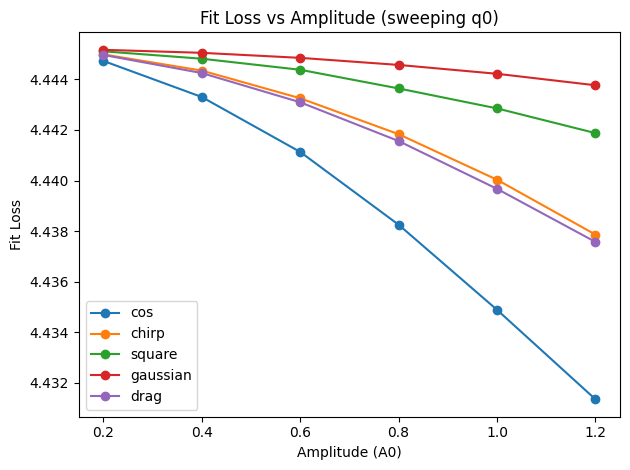

In [22]:
for shape in df['pulse_shape'].unique():
    sel = (df['sweep_q'] == 'q0') & (df['pulse_shape'] == shape) & (df['delta0'] == 0.0)
    plt.plot(df[sel]['A0'], df[sel]['fit_loss'], 'o-', label=shape)

plt.xlabel("Amplitude (A0)")
plt.ylabel("Fit Loss")
plt.title("Fit Loss vs Amplitude (sweeping q0)")
plt.legend()
plt.tight_layout()
plt.savefig("fit_loss_vs_amplitude_q0.png", dpi=1000)
plt.savefig("fit_loss_vs_amplitude_q0.svg")
plt.show()

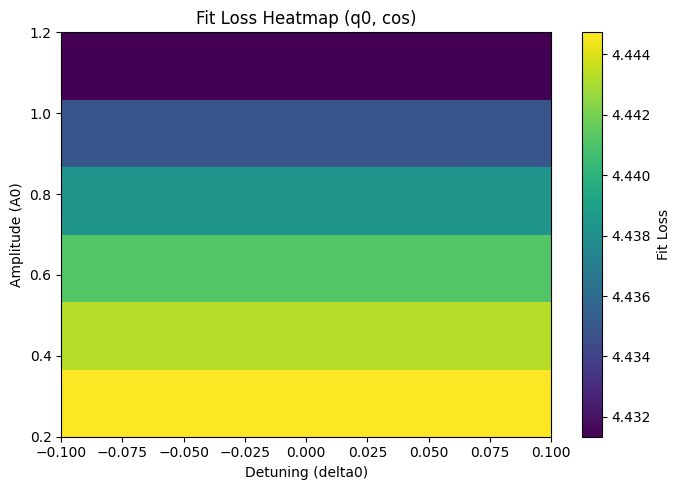

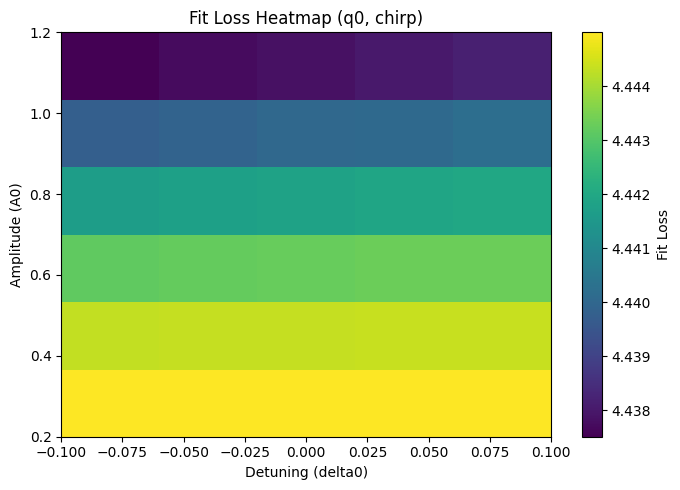

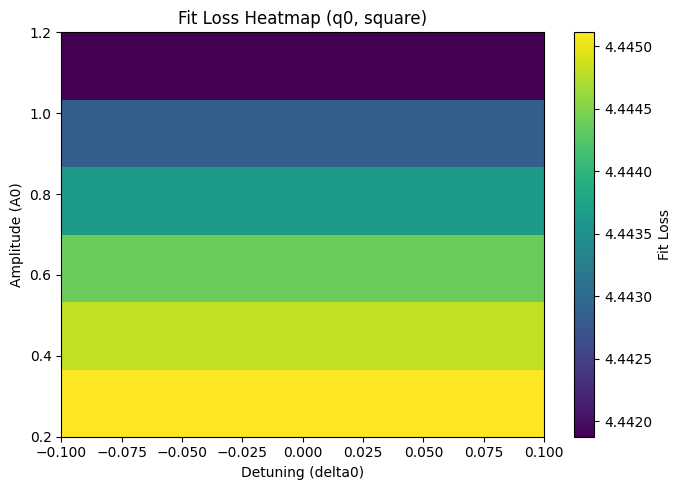

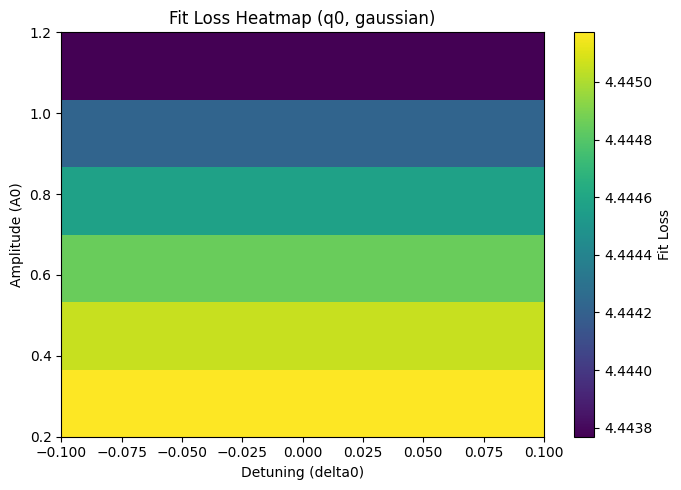

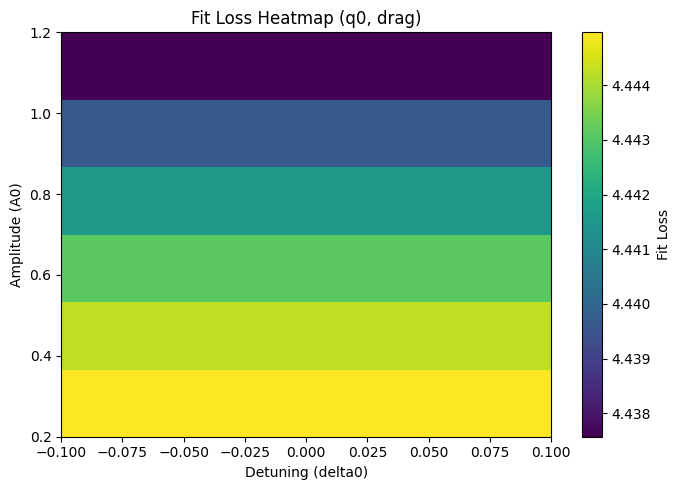

In [24]:
for shape in df['pulse_shape'].unique():
    sel = (df['sweep_q'] == "q0") & (df['pulse_shape'] == shape)
    sub = df[sel].pivot(index="A0", columns="delta0", values="fit_loss")
    plt.figure(figsize=(7, 5))
    plt.imshow(sub, aspect='auto', origin='lower',
               extent=[sub.columns.min(), sub.columns.max(), sub.index.min(), sub.index.max()])
    plt.xlabel("Detuning (delta0)")
    plt.ylabel("Amplitude (A0)")
    plt.title(f"Fit Loss Heatmap (q0, {shape})")
    plt.colorbar(label="Fit Loss")
    plt.tight_layout()
    plt.savefig(f"fit_loss_heatmap_q0_{shape}.png", dpi=1000)
    plt.savefig(f"fit_loss_heatmap_q0_{shape}.svg")
    plt.show()

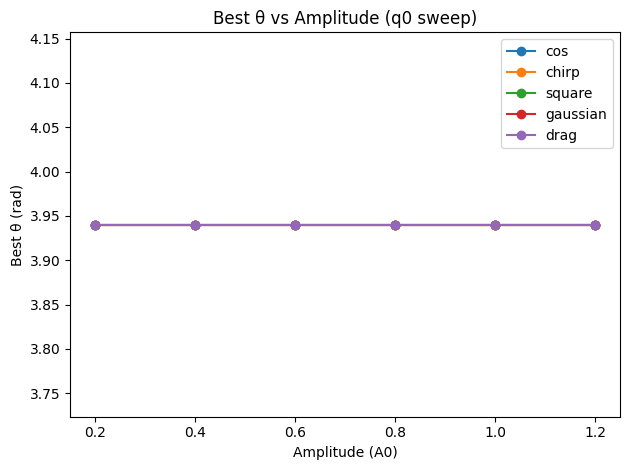

In [25]:
for shape in df['pulse_shape'].unique():
    sel = (df['sweep_q'] == 'q0') & (df['pulse_shape'] == shape) & (df['delta0'] == 0.0)
    plt.plot(df[sel]['A0'], df[sel]['best_theta'], 'o-', label=shape)

plt.xlabel("Amplitude (A0)")
plt.ylabel("Best θ (rad)")
plt.title("Best θ vs Amplitude (q0 sweep)")
plt.legend()
plt.tight_layout()
plt.savefig("best_theta_vs_amplitude_q0.png", dpi=1000)
plt.savefig("best_theta_vs_amplitude_q0.svg")
plt.show()

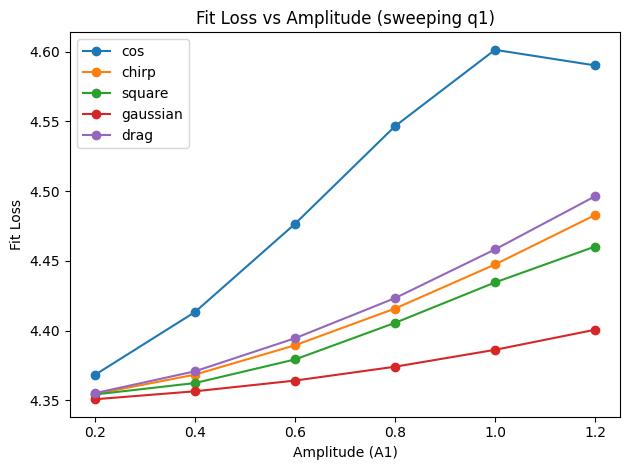

In [26]:
for shape in df['pulse_shape'].unique():
    sel = (df['sweep_q'] == 'q1') & (df['pulse_shape'] == shape) & (df['delta1'] == 0.0)
    plt.plot(df[sel]['A1'], df[sel]['fit_loss'], 'o-', label=shape)

plt.xlabel("Amplitude (A1)")
plt.ylabel("Fit Loss")
plt.title("Fit Loss vs Amplitude (sweeping q1)")
plt.legend()
plt.tight_layout()
plt.savefig("fit_loss_vs_amplitude_q1.png", dpi=1000)
plt.savefig("fit_loss_vs_amplitude_q1.svg")
plt.show()


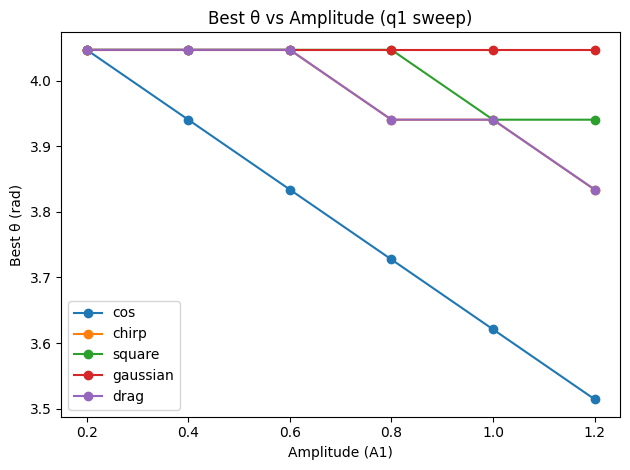

In [27]:
for shape in df['pulse_shape'].unique():
    sel = (df['sweep_q'] == 'q1') & (df['pulse_shape'] == shape) & (df['delta1'] == 0.0)
    plt.plot(df[sel]['A1'], df[sel]['best_theta'], 'o-', label=shape)

plt.xlabel("Amplitude (A1)")
plt.ylabel("Best θ (rad)")
plt.title("Best θ vs Amplitude (q1 sweep)")
plt.legend()
plt.tight_layout()
plt.savefig("best_theta_vs_amplitude_q1.png", dpi=1000)
plt.savefig("best_theta_vs_amplitude_q1.svg")
plt.show()


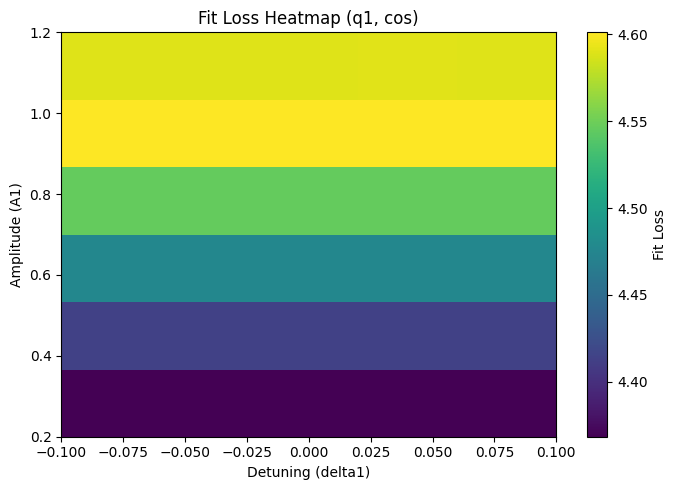

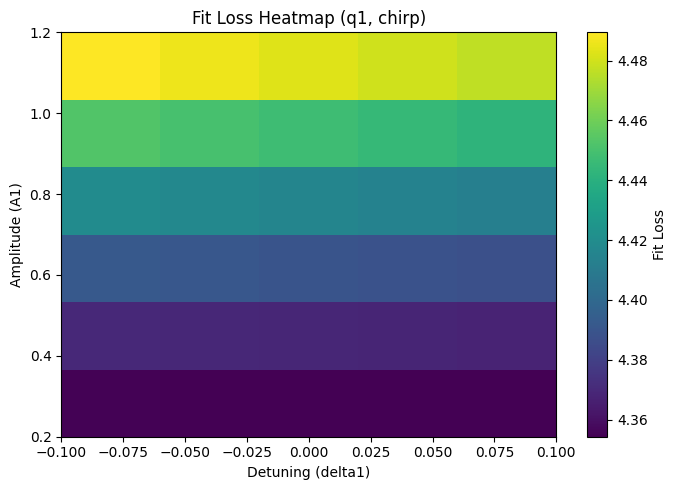

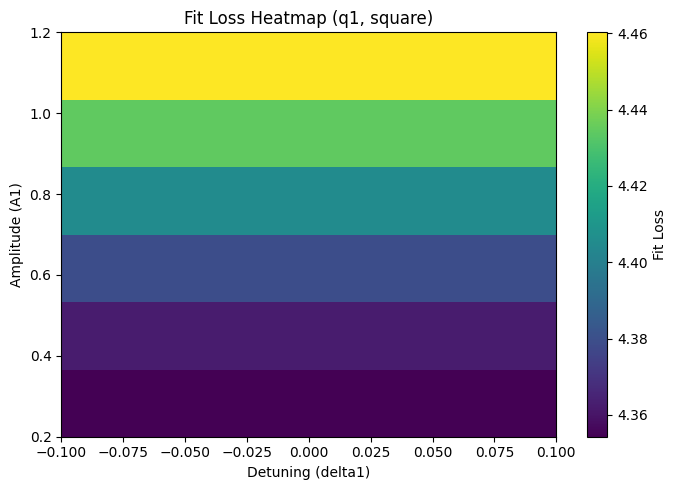

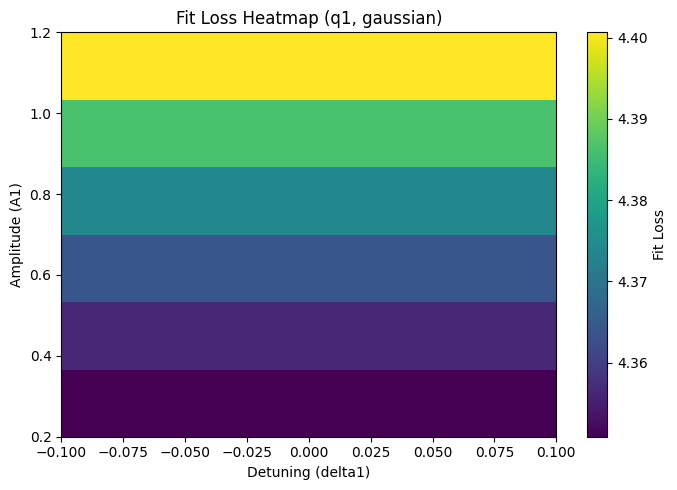

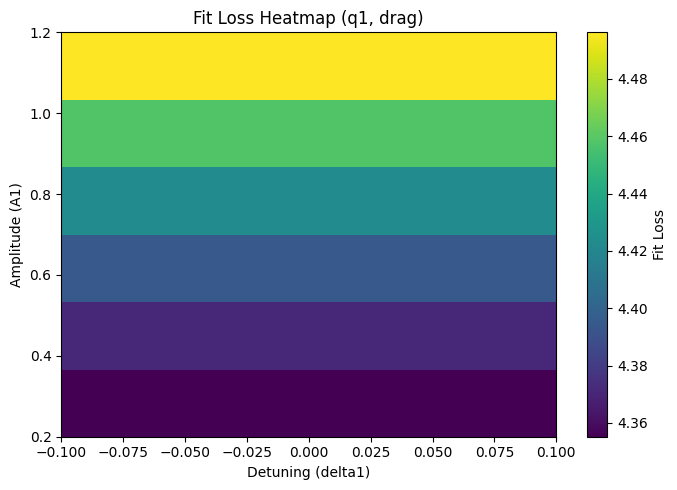

In [28]:
for shape in df['pulse_shape'].unique():
    sel = (df['sweep_q'] == "q1") & (df['pulse_shape'] == shape)
    sub = df[sel].pivot(index="A1", columns="delta1", values="fit_loss")
    plt.figure(figsize=(7, 5))
    plt.imshow(sub, aspect='auto', origin='lower',
               extent=[sub.columns.min(), sub.columns.max(), sub.index.min(), sub.index.max()])
    plt.xlabel("Detuning (delta1)")
    plt.ylabel("Amplitude (A1)")
    plt.title(f"Fit Loss Heatmap (q1, {shape})")
    plt.colorbar(label="Fit Loss")
    plt.tight_layout()
    plt.savefig(f"fit_loss_heatmap_q1_{shape}.png", dpi=1000)
    plt.savefig(f"fit_loss_heatmap_q1_{shape}.svg")
    plt.show()


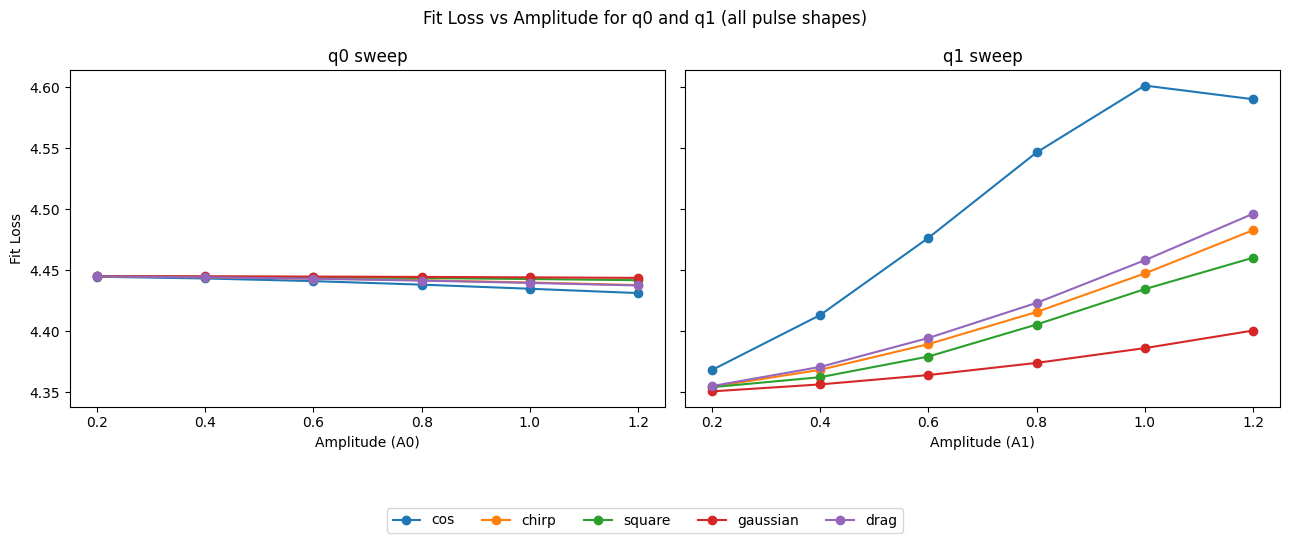

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

for shape in df['pulse_shape'].unique():
    sel_q0 = (df['sweep_q'] == 'q0') & (df['pulse_shape'] == shape) & (df['delta0'] == 0.0)
    axes[0].plot(df[sel_q0]['A0'], df[sel_q0]['fit_loss'], 'o-', label=shape)
    sel_q1 = (df['sweep_q'] == 'q1') & (df['pulse_shape'] == shape) & (df['delta1'] == 0.0)
    axes[1].plot(df[sel_q1]['A1'], df[sel_q1]['fit_loss'], 'o-', label=shape)

axes[0].set_xlabel("Amplitude (A0)")
axes[0].set_ylabel("Fit Loss")
axes[0].set_title("q0 sweep")

axes[1].set_xlabel("Amplitude (A1)")
axes[1].set_title("q1 sweep")


handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.08))

plt.suptitle("Fit Loss vs Amplitude for q0 and q1 (all pulse shapes)")
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig("fit_loss_vs_amplitude_q0q1_allshapes.png", dpi=1000)
plt.savefig("fit_loss_vs_amplitude_q0q1_allshapes.svg")
plt.show()

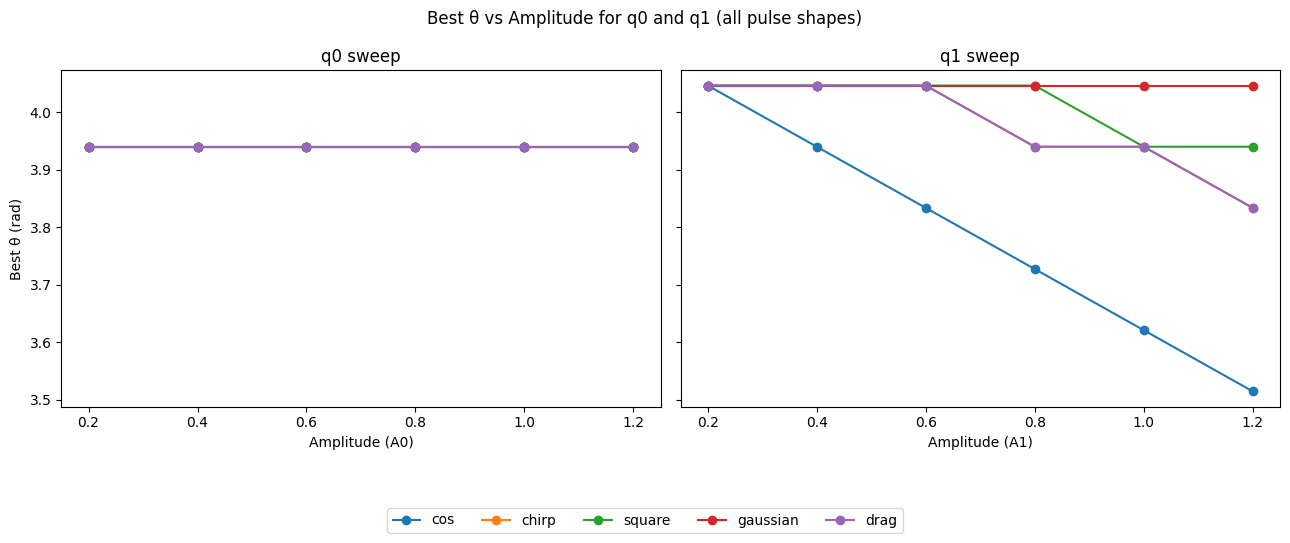

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

for shape in df['pulse_shape'].unique():
    sel_q0 = (df['sweep_q'] == 'q0') & (df['pulse_shape'] == shape) & (df['delta0'] == 0.0)
    axes[0].plot(df[sel_q0]['A0'], df[sel_q0]['best_theta'], 'o-', label=shape)
    sel_q1 = (df['sweep_q'] == 'q1') & (df['pulse_shape'] == shape) & (df['delta1'] == 0.0)
    axes[1].plot(df[sel_q1]['A1'], df[sel_q1]['best_theta'], 'o-', label=shape)

axes[0].set_xlabel("Amplitude (A0)")
axes[0].set_ylabel("Best θ (rad)")
axes[0].set_title("q0 sweep")

axes[1].set_xlabel("Amplitude (A1)")
axes[1].set_title("q1 sweep")


handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.08))

plt.suptitle("Best θ vs Amplitude for q0 and q1 (all pulse shapes)")
plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.savefig("best_theta_vs_amplitude_q0q1_allshapes.png", dpi=1000)
plt.savefig("best_theta_vs_amplitude_q0q1_allshapes.svg")
plt.show()

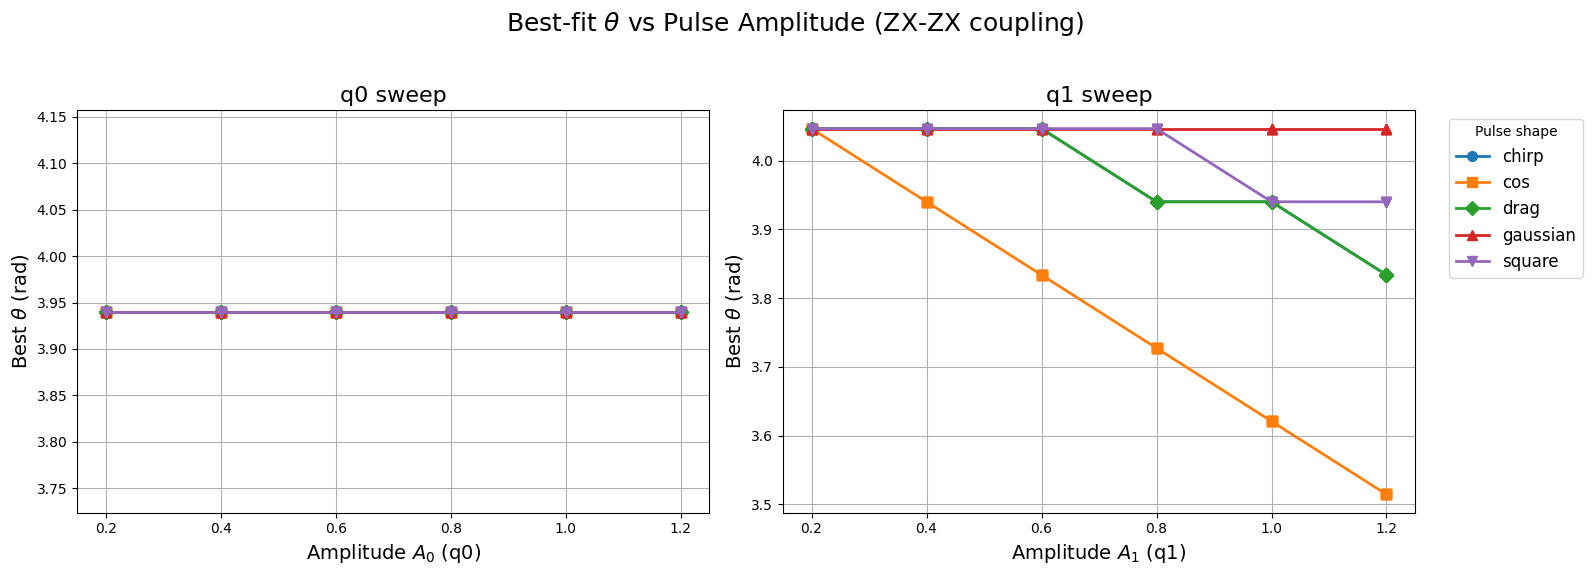

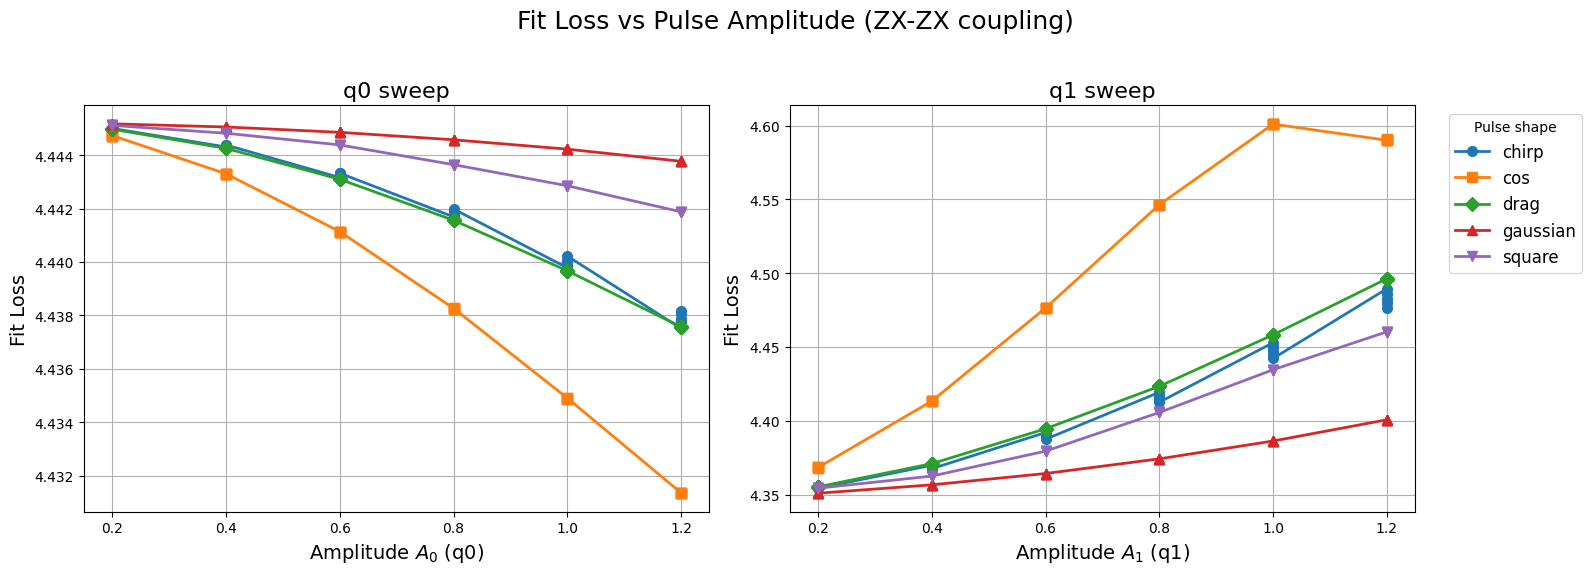

In [33]:
pulse_shapes = sorted(df['pulse_shape'].unique())
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:gray']
markers = ['o', 's', 'D', '^', 'v', '*', 'x']

# ---- Best θ vs Amplitude ----
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(r'Best-fit $\theta$ vs Pulse Amplitude (ZX-ZX coupling)', fontsize=18)

for i, shape in enumerate(pulse_shapes):
    # q0 sweep
    d0 = df[(df['sweep_q']=='q0') & (df['pulse_shape']==shape)]
    axs[0].plot(d0['A0'], d0['best_theta'], label=shape, color=colors[i % len(colors)],
                marker=markers[i % len(markers)], linewidth=2, markersize=7)
    # q1 sweep
    d1 = df[(df['sweep_q']=='q1') & (df['pulse_shape']==shape)]
    axs[1].plot(d1['A1'], d1['best_theta'], label=shape, color=colors[i % len(colors)],
                marker=markers[i % len(markers)], linewidth=2, markersize=7)

axs[0].set_xlabel(r'Amplitude $A_0$ (q0)', fontsize=14)
axs[1].set_xlabel(r'Amplitude $A_1$ (q1)', fontsize=14)
for ax in axs:
    ax.set_ylabel(r'Best $\theta$ (rad)', fontsize=14)
    ax.grid(True)
axs[0].set_title('q0 sweep', fontsize=16)
axs[1].set_title('q1 sweep', fontsize=16)
axs[1].legend(title='Pulse shape', bbox_to_anchor=(1.04,1), loc='upper left', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('best_theta_vs_amplitude_paper.png', dpi=1000)
plt.savefig('best_theta_vs_amplitude_paper.svg')
plt.show()


# ---- Fit Loss vs Amplitude ----
fig, axs = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(r'Fit Loss vs Pulse Amplitude (ZX-ZX coupling)', fontsize=18)

for i, shape in enumerate(pulse_shapes):
    d0 = df[(df['sweep_q']=='q0') & (df['pulse_shape']==shape)]
    axs[0].plot(d0['A0'], d0['fit_loss'], label=shape, color=colors[i % len(colors)],
                marker=markers[i % len(markers)], linewidth=2, markersize=7)
    d1 = df[(df['sweep_q']=='q1') & (df['pulse_shape']==shape)]
    axs[1].plot(d1['A1'], d1['fit_loss'], label=shape, color=colors[i % len(colors)],
                marker=markers[i % len(markers)], linewidth=2, markersize=7)

axs[0].set_xlabel(r'Amplitude $A_0$ (q0)', fontsize=14)
axs[1].set_xlabel(r'Amplitude $A_1$ (q1)', fontsize=14)
for ax in axs:
    ax.set_ylabel('Fit Loss', fontsize=14)
    ax.grid(True)
axs[0].set_title('q0 sweep', fontsize=16)
axs[1].set_title('q1 sweep', fontsize=16)
axs[1].legend(title='Pulse shape', bbox_to_anchor=(1.04,1), loc='upper left', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('fit_loss_vs_amplitude_paper.png', dpi=1000)
plt.savefig('fit_loss_vs_amplitude_paper.svg')
plt.show()


In [34]:
df.to_csv("qpt_attack_results.csv", index=False)
df = pd.read_csv("qpt_attack_results.csv")

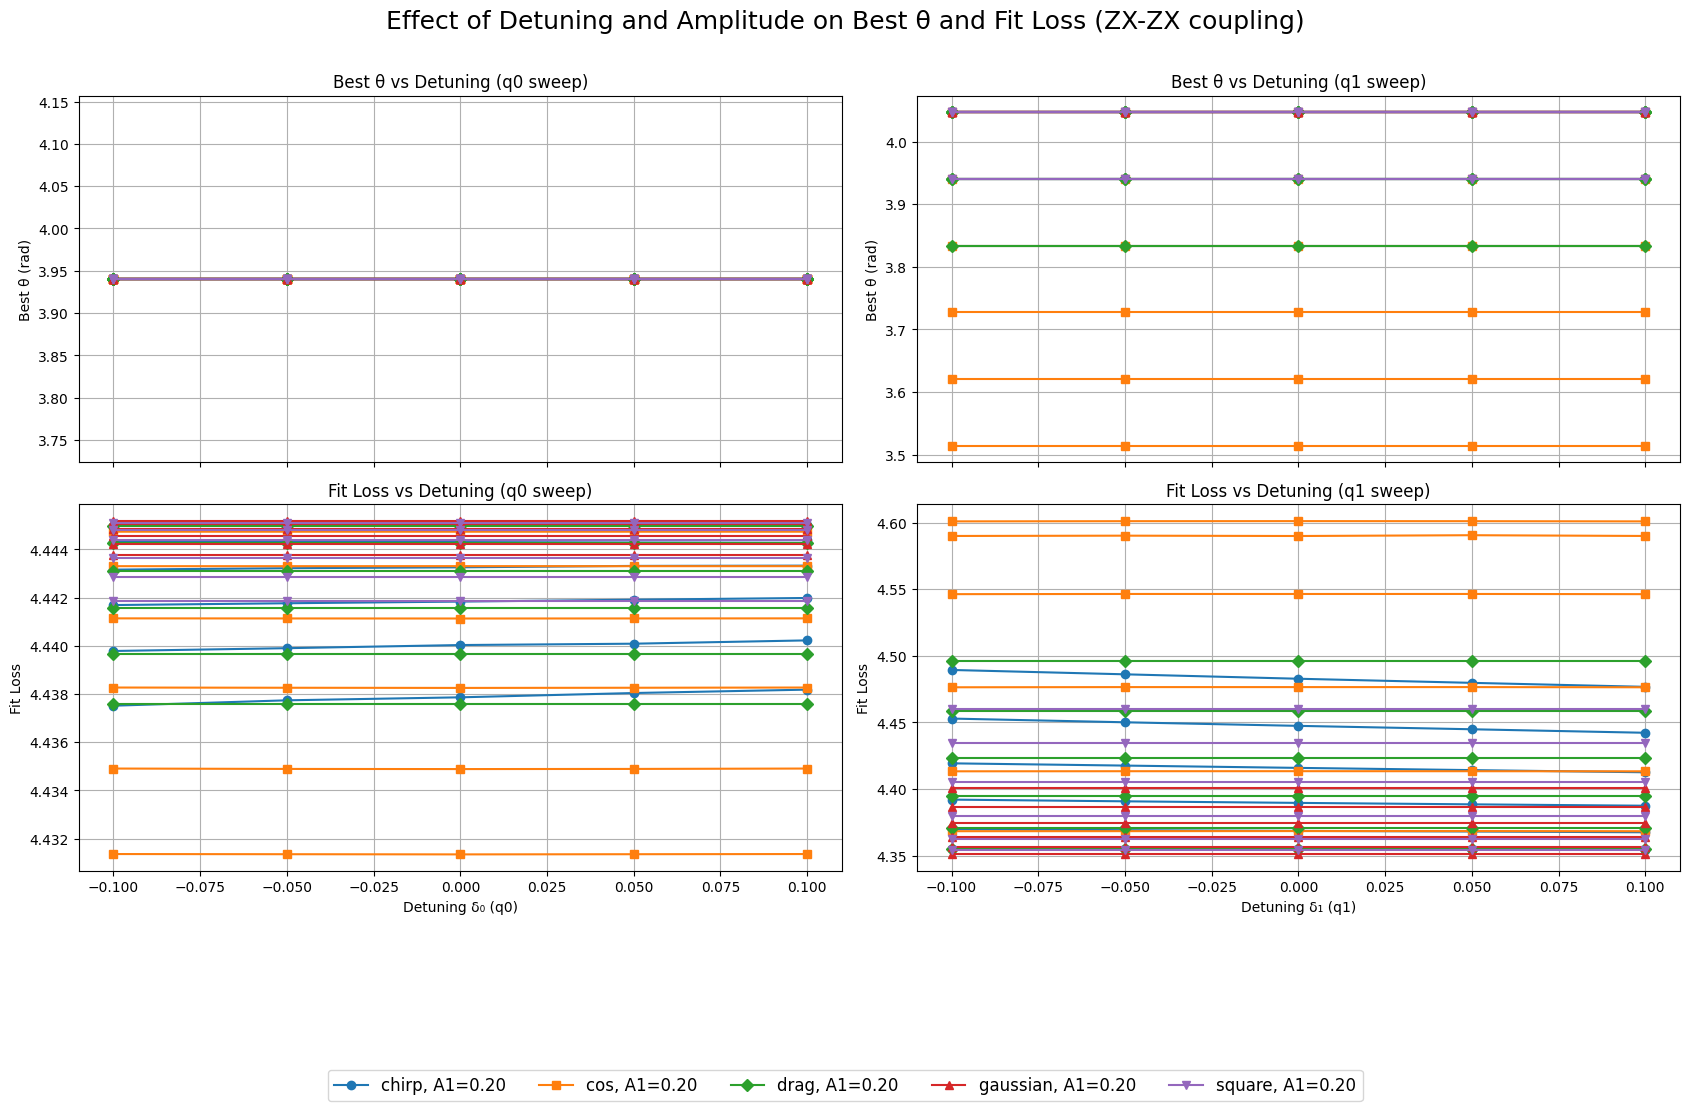

In [39]:
pulse_shapes = sorted(df['pulse_shape'].unique())
amps_q0 = sorted(df[df['sweep_q'] == 'q0']['A0'].unique())
amps_q1 = sorted(df[df['sweep_q'] == 'q1']['A1'].unique())
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:gray']
markers = ['o', 's', 'D', '^', 'v', '*', 'x']

fig, axs = plt.subplots(2, 2, figsize=(17, 10), sharex='col')

for i, shape in enumerate(pulse_shapes):
    # Top-left: best_theta vs delta0 (q0)
    d0 = df[(df['sweep_q'] == 'q0') & (df['pulse_shape'] == shape)]
    for a in amps_q0:
        sel = d0['A0'] == a
        axs[0, 0].plot(d0[sel]['delta0'], d0[sel]['best_theta'],
                       marker=markers[i % len(markers)],
                       color=colors[i % len(colors)],
                       linestyle='-', label=f"{shape}, A0={a:.2f}" if a == amps_q0[0] else "")
    # Bottom-left: fit_loss vs delta0 (q0)
    for a in amps_q0:
        sel = d0['A0'] == a
        axs[1, 0].plot(d0[sel]['delta0'], d0[sel]['fit_loss'],
                       marker=markers[i % len(markers)],
                       color=colors[i % len(colors)],
                       linestyle='-', label=f"{shape}, A0={a:.2f}" if a == amps_q0[0] else "")
    # Top-right: best_theta vs delta1 (q1)
    d1 = df[(df['sweep_q'] == 'q1') & (df['pulse_shape'] == shape)]
    for a in amps_q1:
        sel = d1['A1'] == a
        axs[0, 1].plot(d1[sel]['delta1'], d1[sel]['best_theta'],
                       marker=markers[i % len(markers)],
                       color=colors[i % len(colors)],
                       linestyle='-', label=f"{shape}, A1={a:.2f}" if a == amps_q1[0] else "")
    # Bottom-right: fit_loss vs delta1 (q1)
    for a in amps_q1:
        sel = d1['A1'] == a
        axs[1, 1].plot(d1[sel]['delta1'], d1[sel]['fit_loss'],
                       marker=markers[i % len(markers)],
                       color=colors[i % len(colors)],
                       linestyle='-', label=f"{shape}, A1={a:.2f}" if a == amps_q1[0] else "")

# Axis labels and titles
axs[0, 0].set_title("Best θ vs Detuning (q0 sweep)")
axs[1, 0].set_title("Fit Loss vs Detuning (q0 sweep)")
axs[0, 1].set_title("Best θ vs Detuning (q1 sweep)")
axs[1, 1].set_title("Fit Loss vs Detuning (q1 sweep)")

axs[1, 0].set_xlabel("Detuning δ₀ (q0)")
axs[1, 1].set_xlabel("Detuning δ₁ (q1)")
axs[0, 0].set_ylabel("Best θ (rad)")
axs[1, 0].set_ylabel("Fit Loss")
axs[0, 1].set_ylabel("Best θ (rad)")
axs[1, 1].set_ylabel("Fit Loss")

for ax in axs.flat:
    ax.grid(True)

# Place a single legend for all subplots below the grid
handles, labels = axs[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=6, fontsize=12, bbox_to_anchor=(0.5, -0.12), frameon=True)

plt.suptitle("Effect of Detuning and Amplitude on Best θ and Fit Loss (ZX-ZX coupling)", fontsize=18)
plt.tight_layout(rect=[0, 0.06, 1, 0.97])
plt.savefig("summary_detuning_amplitude_4panel.png", dpi=1000)
plt.savefig("summary_detuning_amplitude_4panel.svg")
plt.show()

